# Візуалізація даних
**Датасет:** Основні прогнозні показники економічного і соціального розвитку України на 2020–2021 роки

In [1]:
import sys
sys.path.append('..')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from src.data_load import download, load

plt.rcParams.update({
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

SCENARIO_COLORS = {
    1: '#2196F3',  # синій
    2: '#4CAF50',  # зелений
    3: '#F44336',  # червоний
}
YEAR_COLORS = {'2020': '#FF9800', '2021': '#9C27B0'}

In [2]:
download()
raw = load()

def parse_num(val):
    if pd.isna(val): return np.nan
    return float(re.sub(r'\s', '', str(val).strip()).replace(',', '.'))

VALUE_COLS = [
    'Прогноз 2020 сценарій 1', 'Прогноз 2020 сценарій 2', 'Прогноз 2020 сценарій 3',
    'Прогноз 2021 сценарій 1', 'Прогноз 2021 сценарій 2', 'Прогноз 2021 сценарій 3',
]
SHORT_COLS = ['s20_1', 's20_2', 's20_3', 's21_1', 's21_2', 's21_3']
INDICATOR_SHORT = [
    'gdp_nominal', 'gdp_real_pct', 'cpi_avg', 'cpi_dec', 'ppi_dec',
    'enterprise_profit', 'wage_fund', 'avg_wage_nom', 'avg_wage_real_pct',
    'employed_mln', 'unemployment_pct', 'real_income_pct',
    'current_account', 'export', 'export_pct', 'import_', 'import_pct',
]
INDICATOR_UK = [
    'ВВП номінальний, млрд. грн', 'ВВП реальний, %', 'ІСЦ середній, %',
    'ІСЦ грудень/грудень, %', 'Індекс цін виробників, %',
    'Прибуток підприємств, млрд. грн', 'Фонд оплати праці, млрд. грн',
    'Середня зарплата, грн', 'Середня зарплата реальна, %',
    'Зайняті 15–70 р., млн. осіб', 'Безробіття МОП, %',
    'Реальні доходи, %', 'Сальдо поточного рахунку, млн. USD',
    'Експорт, млн. USD', 'Експорт, %', 'Імпорт, млн. USD', 'Імпорт, %',
]

df = raw.copy()
df.columns = ['idx', 'indicator'] + VALUE_COLS
df['short'] = INDICATOR_SHORT
df['indicator_uk'] = INDICATOR_UK
for vc, sc in zip(VALUE_COLS, SHORT_COLS):
    df[sc] = df[vc].apply(parse_num)
df = df[['idx', 'short', 'indicator_uk'] + SHORT_COLS]

# long формат
records = []
for _, row in df.iterrows():
    for year in (2020, 2021):
        for sc in (1, 2, 3):
            records.append({
                'short': row['short'], 'indicator_uk': row['indicator_uk'],
                'year': year, 'scenario': sc,
                'value': row[f's{str(year)[2:]}_{sc}'],
            })
long = pd.DataFrame(records)
pivot = long.pivot_table(index=['year','scenario'], columns='short', values='value')
print('Дані готові:', df.shape)

[skip] Файл вже існує: D:\code\AI\open-data-ai-analytics\data\raw\nabir-16-2020-2021.csv
[ok] Завантажено 17 рядків, 8 колонок (encoding=cp1251)
Дані готові: (17, 9)


## 1. ВВП: номінальний та реальний по сценаріях

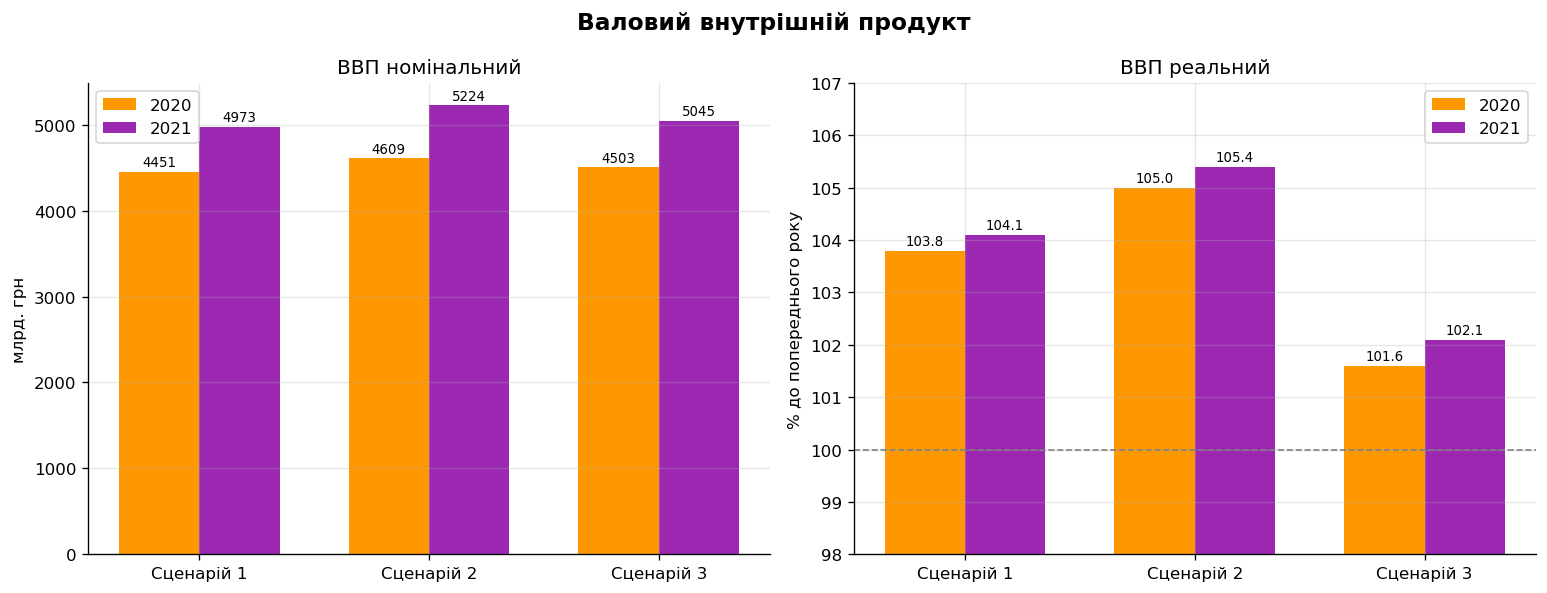

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Валовий внутрішній продукт', fontsize=14, fontweight='bold')

scenarios = [1, 2, 3]
labels = ['Сценарій 1', 'Сценарій 2', 'Сценарій 3']
x = np.arange(len(scenarios))
width = 0.35

# Номінальний ВВП
ax = axes[0]
vals_2020 = [pivot.loc[(2020, sc), 'gdp_nominal'] for sc in scenarios]
vals_2021 = [pivot.loc[(2021, sc), 'gdp_nominal'] for sc in scenarios]
ax.bar(x - width/2, vals_2020, width, label='2020', color=YEAR_COLORS['2020'])
ax.bar(x + width/2, vals_2021, width, label='2021', color=YEAR_COLORS['2021'])
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylabel('млрд. грн')
ax.set_title('ВВП номінальний')
ax.legend()
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
            f'{bar.get_height():.0f}', ha='center', va='bottom', fontsize=8)

# Реальний ВВП %
ax = axes[1]
vals_2020 = [pivot.loc[(2020, sc), 'gdp_real_pct'] for sc in scenarios]
vals_2021 = [pivot.loc[(2021, sc), 'gdp_real_pct'] for sc in scenarios]
ax.bar(x - width/2, vals_2020, width, label='2020', color=YEAR_COLORS['2020'])
ax.bar(x + width/2, vals_2021, width, label='2021', color=YEAR_COLORS['2021'])
ax.axhline(100, color='grey', linestyle='--', linewidth=1)
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylabel('% до попереднього року')
ax.set_title('ВВП реальний')
ax.set_ylim(98, 107)
ax.legend()
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../reports/figures/viz_gdp.png', bbox_inches='tight')
plt.show()

## 2. Інфляція: ІСЦ та Індекс цін виробників

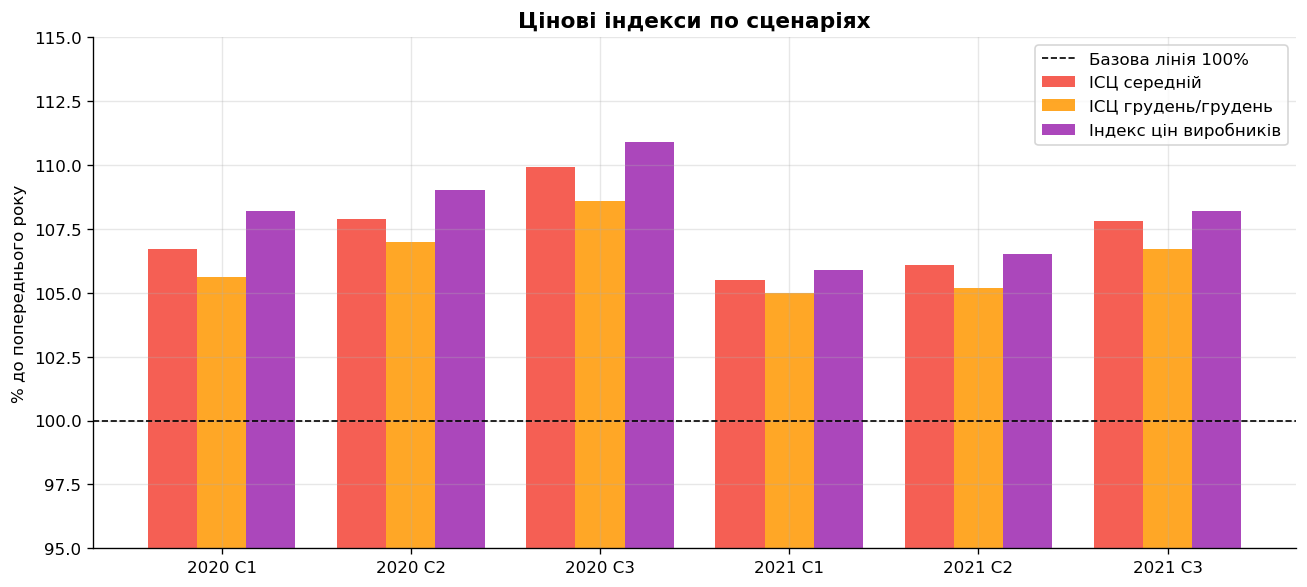

In [4]:
fig, ax = plt.subplots(figsize=(11, 5))

ind_map = {'cpi_avg': 'ІСЦ середній', 'cpi_dec': 'ІСЦ грудень/грудень', 'ppi_dec': 'Індекс цін виробників'}
bar_groups = [(2020, 1), (2020, 2), (2020, 3), (2021, 1), (2021, 2), (2021, 3)]
x_labels = ['2020 С1','2020 С2','2020 С3','2021 С1','2021 С2','2021 С3']
x = np.arange(len(bar_groups))
width = 0.26
offsets = [-width, 0, width]
colors_inf = ['#F44336', '#FF9800', '#9C27B0']

for (ind, label), offset, color in zip(ind_map.items(), offsets, colors_inf):
    vals = [pivot.loc[g, ind] for g in bar_groups]
    ax.bar(x + offset, vals, width, label=label, color=color, alpha=0.85)

ax.axhline(100, color='black', linestyle='--', linewidth=1, label='Базова лінія 100%')
ax.set_xticks(x); ax.set_xticklabels(x_labels)
ax.set_ylabel('% до попереднього року')
ax.set_title('Цінові індекси по сценаріях', fontsize=13, fontweight='bold')
ax.set_ylim(95, 115)
ax.legend()

plt.tight_layout()
plt.savefig('../reports/figures/viz_inflation.png', bbox_inches='tight')
plt.show()

## 3. Ринок праці: зайнятість і безробіття

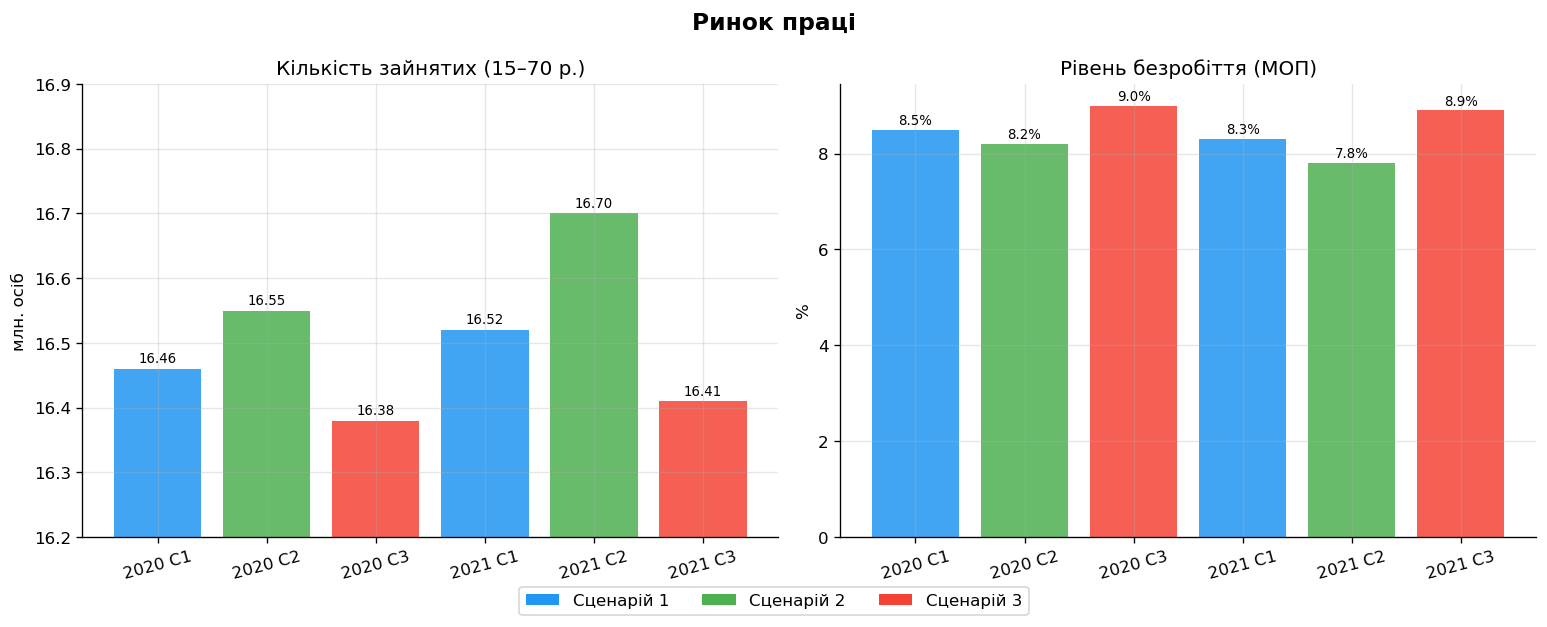

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Ринок праці', fontsize=14, fontweight='bold')

x_labels = ['2020 С1','2020 С2','2020 С3','2021 С1','2021 С2','2021 С3']
x = np.arange(6)
bar_groups = [(2020,1),(2020,2),(2020,3),(2021,1),(2021,2),(2021,3)]
sc_colors_list = [SCENARIO_COLORS[g[1]] for g in bar_groups]

# Зайнятість
ax = axes[0]
vals = [pivot.loc[g, 'employed_mln'] for g in bar_groups]
bars = ax.bar(x, vals, color=sc_colors_list, alpha=0.85)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=8)
ax.set_xticks(x); ax.set_xticklabels(x_labels, rotation=15)
ax.set_ylabel('млн. осіб')
ax.set_title('Кількість зайнятих (15–70 р.)')
ax.set_ylim(16.2, 16.9)

# Безробіття
ax = axes[1]
vals = [pivot.loc[g, 'unemployment_pct'] for g in bar_groups]
bars = ax.bar(x, vals, color=sc_colors_list, alpha=0.85)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=8)
ax.set_xticks(x); ax.set_xticklabels(x_labels, rotation=15)
ax.set_ylabel('%')
ax.set_title('Рівень безробіття (МОП)')

# Легенда сценаріїв
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=SCENARIO_COLORS[i], label=f'Сценарій {i}') for i in (1,2,3)]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.04))

plt.tight_layout()
plt.savefig('../reports/figures/viz_labour_market.png', bbox_inches='tight')
plt.show()

## 4. Заробітна плата та реальні доходи

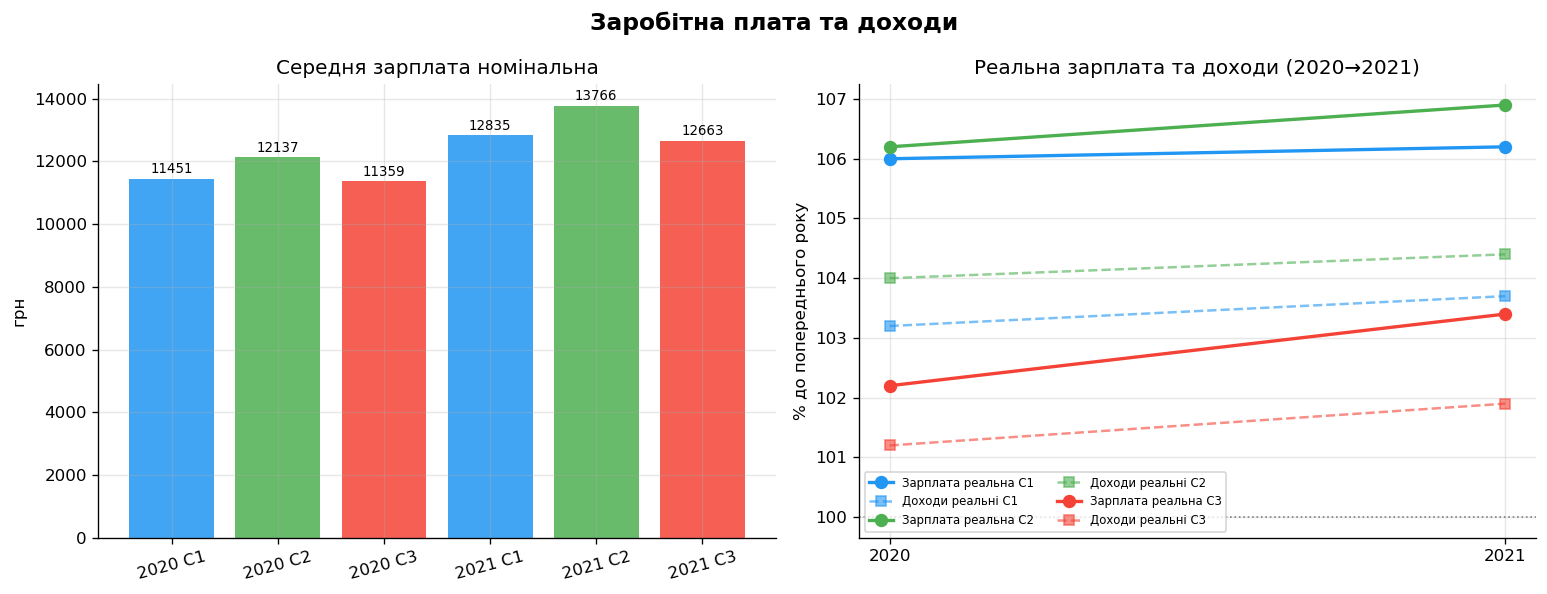

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Заробітна плата та доходи', fontsize=14, fontweight='bold')

bar_groups = [(2020,1),(2020,2),(2020,3),(2021,1),(2021,2),(2021,3)]
x_labels = ['2020 С1','2020 С2','2020 С3','2021 С1','2021 С2','2021 С3']
x = np.arange(6)
sc_colors_list = [SCENARIO_COLORS[g[1]] for g in bar_groups]

# Середня зарплата номінальна
ax = axes[0]
vals = [pivot.loc[g, 'avg_wage_nom'] for g in bar_groups]
bars = ax.bar(x, vals, color=sc_colors_list, alpha=0.85)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 80,
            f'{bar.get_height():.0f}', ha='center', va='bottom', fontsize=8)
ax.set_xticks(x); ax.set_xticklabels(x_labels, rotation=15)
ax.set_ylabel('грн')
ax.set_title('Середня зарплата номінальна')

# Реальна зарплата та реальні доходи — лінійний графік
ax = axes[1]
for sc in (1, 2, 3):
    wage_vals  = [pivot.loc[(yr, sc), 'avg_wage_real_pct'] for yr in (2020, 2021)]
    income_vals = [pivot.loc[(yr, sc), 'real_income_pct'] for yr in (2020, 2021)]
    ax.plot([2020, 2021], wage_vals, 'o-', color=SCENARIO_COLORS[sc],
            linewidth=2, markersize=7, label=f'Зарплата реальна С{sc}')
    ax.plot([2020, 2021], income_vals, 's--', color=SCENARIO_COLORS[sc],
            linewidth=1.5, markersize=6, alpha=0.6, label=f'Доходи реальні С{sc}')

ax.axhline(100, color='grey', linestyle=':', linewidth=1)
ax.set_xticks([2020, 2021])
ax.set_ylabel('% до попереднього року')
ax.set_title('Реальна зарплата та доходи (2020→2021)')
ax.legend(fontsize=7, ncol=2)

plt.tight_layout()
plt.savefig('../reports/figures/viz_wages.png', bbox_inches='tight')
plt.show()

## 5. Зовнішня торгівля: експорт та імпорт

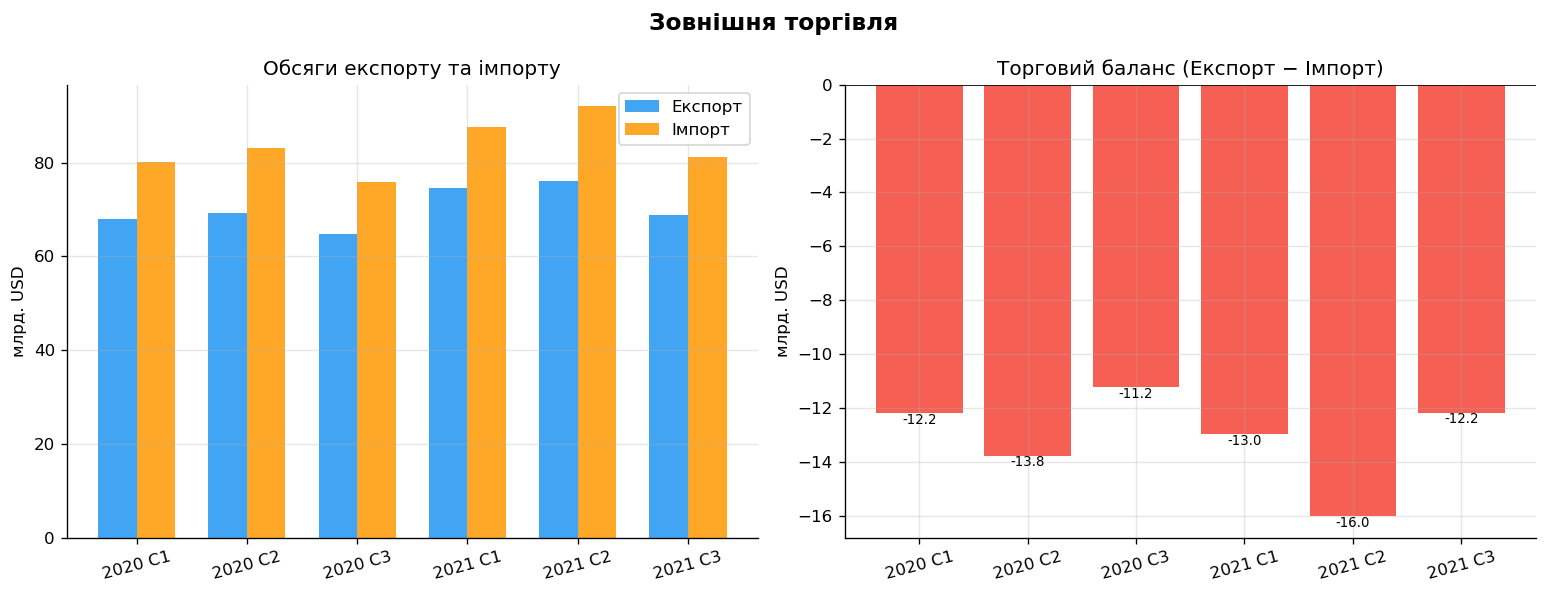

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Зовнішня торгівля', fontsize=14, fontweight='bold')

bar_groups = [(2020,1),(2020,2),(2020,3),(2021,1),(2021,2),(2021,3)]
x_labels = ['2020 С1','2020 С2','2020 С3','2021 С1','2021 С2','2021 С3']
x = np.arange(6)
width = 0.35

# Абсолютні обсяги
ax = axes[0]
exp_vals = [pivot.loc[g, 'export'] / 1000 for g in bar_groups]
imp_vals = [pivot.loc[g, 'import_'] / 1000 for g in bar_groups]
ax.bar(x - width/2, exp_vals, width, label='Експорт', color='#2196F3', alpha=0.85)
ax.bar(x + width/2, imp_vals, width, label='Імпорт',  color='#FF9800', alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(x_labels, rotation=15)
ax.set_ylabel('млрд. USD')
ax.set_title('Обсяги експорту та імпорту')
ax.legend()

# Торговий баланс
ax = axes[1]
balance = [pivot.loc[g, 'export'] - pivot.loc[g, 'import_'] for g in bar_groups]
bar_colors = ['#4CAF50' if v >= 0 else '#F44336' for v in balance]
bars = ax.bar(x, [b/1000 for b in balance], color=bar_colors, alpha=0.85)
for bar in bars:
    ypos = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            ypos + (0.2 if ypos >= 0 else -0.5),
            f'{ypos:.1f}', ha='center', va='bottom', fontsize=8)
ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(x); ax.set_xticklabels(x_labels, rotation=15)
ax.set_ylabel('млрд. USD')
ax.set_title('Торговий баланс (Експорт − Імпорт)')

plt.tight_layout()
plt.savefig('../reports/figures/viz_trade.png', bbox_inches='tight')
plt.show()

## 6. Порівняння сценаріїв: радарний графік

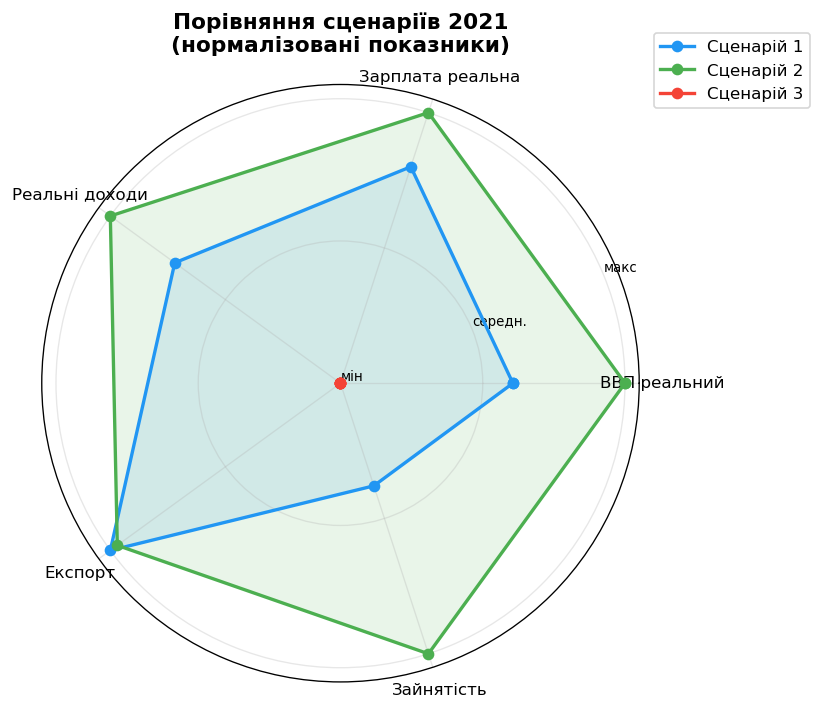

In [8]:
# Нормалізовані відносні значення для 2021 по ключових показниках
radar_cols = ['gdp_real_pct', 'avg_wage_real_pct', 'real_income_pct',
              'export_pct', 'employed_mln']
radar_labels = ['ВВП реальний', 'Зарплата реальна', 'Реальні доходи',
                'Експорт', 'Зайнятість']

# Нормалізуємо кожен показник у діапазон [0, 1] між мін і макс по сценаріях 2021
data_2021 = {sc: [pivot.loc[(2021, sc), col] for col in radar_cols] for sc in (1, 2, 3)}
arr = np.array(list(data_2021.values()))
arr_norm = (arr - arr.min(axis=0)) / (arr.max(axis=0) - arr.min(axis=0) + 1e-9)

N = len(radar_cols)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # замкнути коло

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for i, sc in enumerate((1, 2, 3)):
    values = arr_norm[i].tolist() + arr_norm[i][:1].tolist()
    ax.plot(angles, values, 'o-', color=SCENARIO_COLORS[sc], linewidth=2, label=f'Сценарій {sc}')
    ax.fill(angles, values, color=SCENARIO_COLORS[sc], alpha=0.12)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_labels, fontsize=10)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['мін', 'середн.', 'макс'], fontsize=8)
ax.set_title('Порівняння сценаріїв 2021\n(нормалізовані показники)', fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig('../reports/figures/viz_radar.png', bbox_inches='tight')
plt.show()

## 7. Динаміка зростання показників 2020 → 2021

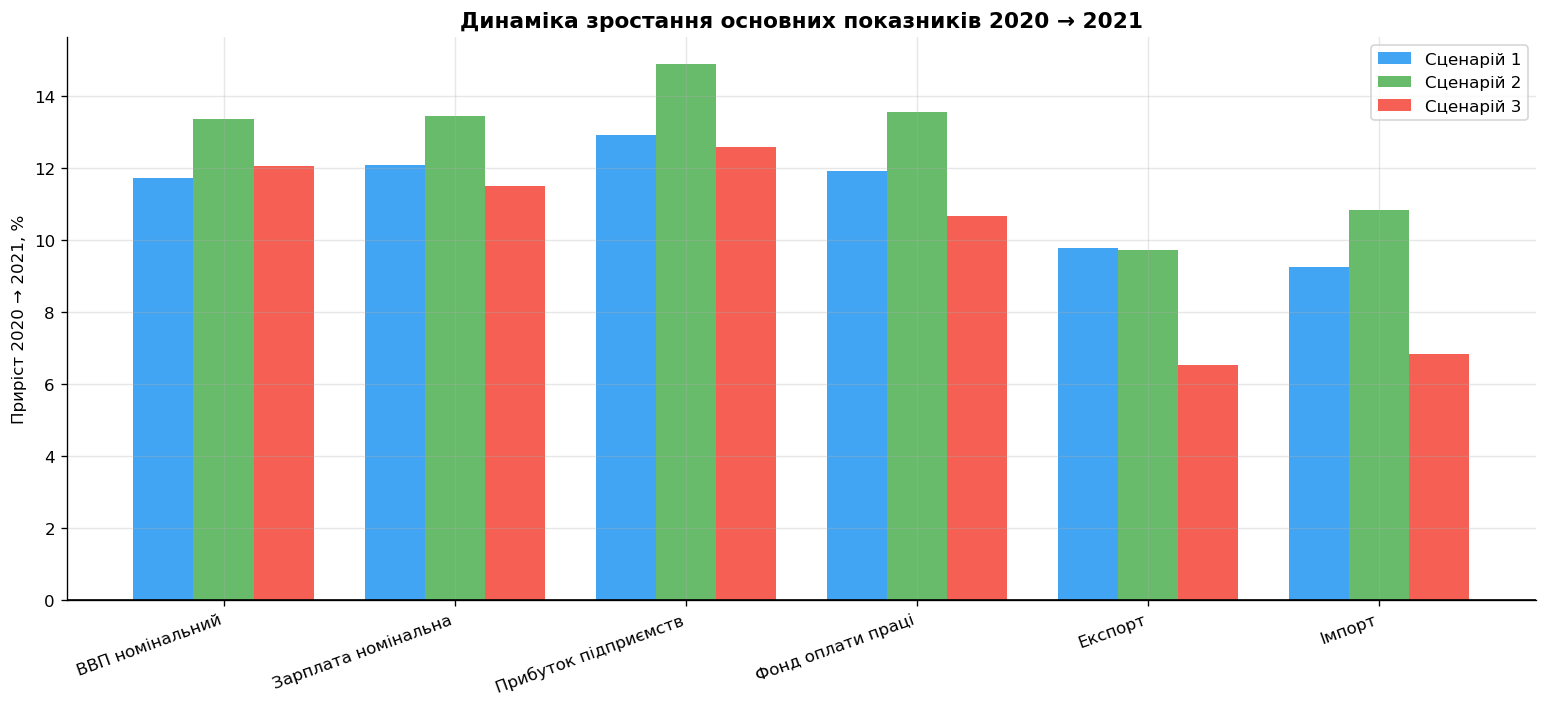

In [9]:
# Приріст 2021 vs 2020 для кожного сценарію (у %)
growth_cols = {
    'gdp_nominal':       'ВВП номінальний',
    'avg_wage_nom':      'Зарплата номінальна',
    'enterprise_profit': 'Прибуток підприємств',
    'wage_fund':         'Фонд оплати праці',
    'export':            'Експорт',
    'import_':           'Імпорт',
}

growth_data = {}
for col, label in growth_cols.items():
    growth_data[label] = {
        sc: (pivot.loc[(2021, sc), col] / pivot.loc[(2020, sc), col] - 1) * 100
        for sc in (1, 2, 3)
    }

labels = list(growth_cols.values())
x = np.arange(len(labels))
width = 0.26

fig, ax = plt.subplots(figsize=(13, 6))
for i, sc in enumerate((1, 2, 3)):
    vals = [growth_data[lbl][sc] for lbl in labels]
    bars = ax.bar(x + (i - 1) * width, vals, width,
                  label=f'Сценарій {sc}', color=SCENARIO_COLORS[sc], alpha=0.85)

ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha='right')
ax.set_ylabel('Приріст 2020 → 2021, %')
ax.set_title('Динаміка зростання основних показників 2020 → 2021', fontsize=13, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../reports/figures/viz_growth_dynamics.png', bbox_inches='tight')
plt.show()